## Lesson-07 Recurrent Neural Networks 循环神经网络的原理及应用

循环神经网络是我们常用的一个网络模型，这个网络能够处理例如字符串，时间序列等问题。因为模型对序列问题的优势，RNN模型已经成为了自然语言处理问题的常见方法。

在本课程的作业中，我们将完成三个任务：

0. 基于任务驱动，实际感受并能够初步使用pytorch；
1. 使用RNN模型进行名字的国籍分类；(这个程序主要是参考的Pytorch文档)

RNN也可以用于金融数据的预测，例如:
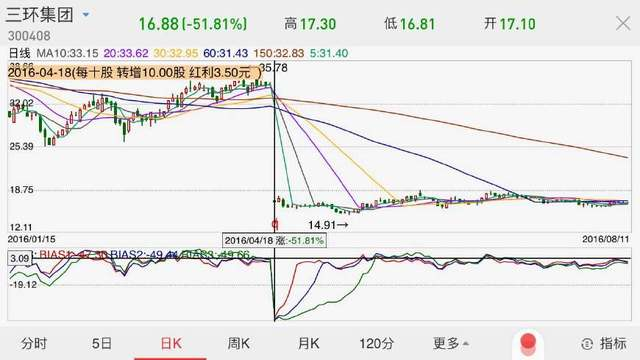

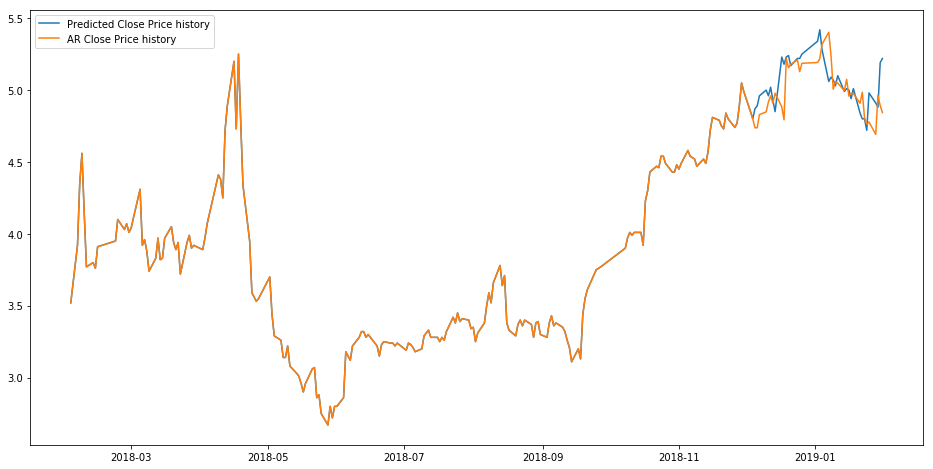

上图中蓝色的部分就是预测值， 关于RNN模型对金融数据的预测，我们只会会增加专门的研讨课程，给大家讲解

我们今天带给大家的是使用RNN进行名字的国籍分类:

## 1. 使用RNN模型进行名字的国籍分类

首先，我们下载数据: 将这个数据置于和我们jupyter notebook位置相同的地方

#### 1.1 我们利用通配符，打印出所有的文件

In [1]:
from io import open
import glob
import os
import matplotlib.pyplot as plt


def find_files(path): return glob.glob(path)

print(find_files('data/names/*.txt'))

['data/names/Czech.txt', 'data/names/German.txt', 'data/names/Arabic.txt', 'data/names/Japanese.txt', 'data/names/Chinese.txt', 'data/names/Vietnamese.txt', 'data/names/Russian.txt', 'data/names/French.txt', 'data/names/Irish.txt', 'data/names/English.txt', 'data/names/Spanish.txt', 'data/names/Greek.txt', 'data/names/Italian.txt', 'data/names/Portuguese.txt', 'data/names/Scottish.txt', 'data/names/Dutch.txt', 'data/names/Korean.txt', 'data/names/Polish.txt']


### 1.2 名字里边包含不少非Ascii码，为了简便问题，我们将他们转化为Ascii码

In [2]:
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicode_2_Ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicode_2_Ascii('Ślusàrski'))

Slusarski


### Step1.3 然后我们建立类别和对于的名字的dictionary对应

In [3]:
# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def read_lines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicode_2_Ascii(line) for line in lines]

for filename in find_files('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = read_lines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

In [4]:
n_categories

18

In [5]:
category_lines['Chinese'][:10]

['Ang', 'AuYong', 'Bai', 'Ban', 'Bao', 'Bei', 'Bian', 'Bui', 'Cai', 'Cao']

### 1.4 这一次我们使用pytorch, 来进行向量化

In [6]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letter_to_index(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letter_to_tensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letter_to_index(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def line_to_tensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letter_to_index(letter)] = 1
    return tensor

print(letter_to_index('J'))

print(line_to_tensor('Jones').size())

35
torch.Size([5, 1, 57])


In [7]:
line_to_tensor('Jones')

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0

我们可以看到，是对名字里的每个字符做了 one-hot操作

### 1.5 然后，我们构建一个这样的RNN网络

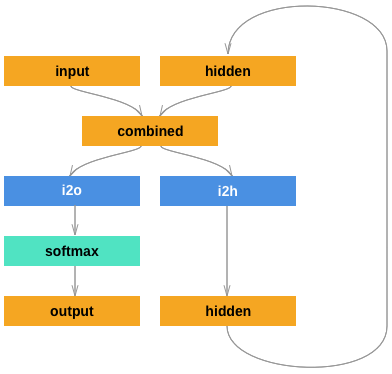

In [8]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)#全连接网络
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128

In [9]:
rnn = RNN(n_letters, n_hidden, n_categories)

### 1.6 运行一步RNN

为了运行这个rnn网络，我们需要给他一个input，然后再加上一个hidden state. 然后我们就能过获得一个output，这个output便是的是这个单词的属于每个国家的概率，和接下来的hidden state.

In [10]:
input = letter_to_tensor('A')
hidden =torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)

In [11]:
output

tensor([[-2.9127, -2.8634, -2.8168, -2.9027, -2.9266, -2.8625, -2.9432, -2.8822,
         -2.9163, -2.9363, -2.7908, -2.8577, -2.9500, -2.8962, -3.0209, -2.8711,
         -2.8258, -2.8768]], grad_fn=<LogSoftmaxBackward>)

In [12]:
next_hidden

tensor([[-0.0166, -0.0220, -0.0409,  0.0739, -0.0412,  0.0092,  0.0182, -0.0134,
         -0.1312,  0.1263,  0.0054, -0.0408,  0.0221, -0.0711, -0.0301,  0.0043,
         -0.0895, -0.0186,  0.1127,  0.0096, -0.1329,  0.0485, -0.0829,  0.0988,
          0.0919, -0.1213, -0.0018,  0.0329, -0.0762,  0.0288, -0.0062, -0.0356,
         -0.0664, -0.0875, -0.1003,  0.0445,  0.0150, -0.1202, -0.1116,  0.0037,
          0.0101, -0.0517,  0.0362,  0.0087,  0.0066, -0.0239,  0.0314, -0.0142,
          0.0973, -0.0042, -0.0669,  0.0839,  0.0358, -0.0497,  0.0174, -0.0132,
         -0.1068,  0.0469, -0.0709,  0.0855, -0.1107,  0.0453, -0.0098,  0.0796,
         -0.0256,  0.0174, -0.0021,  0.0513, -0.0534, -0.0492, -0.1021, -0.0269,
          0.1040,  0.0603,  0.0172,  0.0646,  0.0085,  0.0290, -0.0417,  0.0184,
          0.0162, -0.0012,  0.0739, -0.0312, -0.0449, -0.0570,  0.0495,  0.0937,
          0.0385, -0.0597,  0.0461, -0.0336,  0.0182, -0.0146, -0.0299,  0.0168,
          0.0545, -0.0040, -

然后，我们可以使用 line_to_tensor, 把一句话直接变成 tensor

In [13]:
input = line_to_tensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.9127, -2.8634, -2.8168, -2.9027, -2.9266, -2.8625, -2.9432, -2.8822,
         -2.9163, -2.9363, -2.7908, -2.8577, -2.9500, -2.8962, -3.0209, -2.8711,
         -2.8258, -2.8768]], grad_fn=<LogSoftmaxBackward>)


这个output，就是基于目前的RNN参数，预测出来的国籍概率分布。显然是不对的，因为里边的参数都是随机的。

### 1.7 更好的观察结果

为了能够更好的看到我们的训练结果，我们需要把输出的tensor变成我们能看懂的国籍

In [14]:
def category_from_output(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i



对于刚刚产生的output，我们使用这个函数

In [15]:
print(category_from_output(output))

('Spanish', 10)


### 1.8 随机生成训练数据

In [16]:
import random

def sample(l):
    return l[random.randint(0, len(l) - 1)]

def sample_trainning():
    category = sample(all_categories)
    line = sample(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long) # 张量
    line_tensor = line_to_tensor(line) # 生成one-hot
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = sample_trainning()
    print('category =', category, '/ line =', line)

category = Russian / line = Hitarov
category = Portuguese / line = Pinheiro
category = Portuguese / line = Machado
category = Korean / line = Jong
category = French / line = Sauvageot
category = Arabic / line = Kassis
category = Polish / line = Chmiel
category = English / line = Uddin
category = Polish / line = Adamczyk
category = Arabic / line = Maroun


### 因为我们这个模型需要 softmax 来获得每个类别，所以我们使用cross-entropy作为Loss函数

In [17]:
criterion = nn.CrossEntropyLoss()

In [20]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad() #清零

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden) #TODO:增加训练数据，要重新训练了？

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

In [21]:
import time
import math

n_iters = 1800 # 这个数字你可以调大一些
print_every = 100
plot_every = 100


# Keep track of losses for plotting
current_loss = 0
all_losses = []

def time_since(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = sample_trainning()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = category_from_output(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, time_since(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

100 5% (0m 0s) 2.7552 Shriver / German ✓
200 11% (0m 0s) 2.7738 Hang / Korean ✗ (Chinese)
300 16% (0m 0s) 3.0463 Groos / Greek ✗ (German)
400 22% (0m 0s) 3.0652 Fay / Scottish ✗ (French)
500 27% (0m 1s) 2.7397 Chlebek / Czech ✗ (Polish)
600 33% (0m 1s) 2.7232 Dao / Vietnamese ✓
700 38% (0m 1s) 2.9097 Levite / Japanese ✗ (Russian)
800 44% (0m 1s) 2.7039 Docherty / Scottish ✓
900 50% (0m 2s) 2.8692 Koemans / Greek ✗ (Dutch)
1000 55% (0m 2s) 2.9137 Choe / Scottish ✗ (Korean)
1100 61% (0m 2s) 2.6045 Sadowski / Polish ✓
1200 66% (0m 2s) 2.6907 Kikuchi / Italian ✗ (Japanese)
1300 72% (0m 3s) 2.8180 Houte / Scottish ✗ (Dutch)
1400 77% (0m 3s) 3.0110 Roy / Scottish ✗ (French)
1500 83% (0m 3s) 2.4567 Meeuwissen / Dutch ✓
1600 88% (0m 3s) 2.6657 Maslanka / Japanese ✗ (Polish)
1700 94% (0m 4s) 2.5127 Poggi / Italian ✓
1800 100% (0m 4s) 2.5929 Ceallach / Dutch ✗ (Irish)


### 1.9 观察Loss的变化

In [22]:
all_losses

[2.789912078380585,
 2.8083447718620302,
 2.7947964310646056,
 2.7701976180076597,
 2.793034300804138,
 2.752068920135498,
 2.803673551082611,
 2.7737375259399415,
 2.7568417310714723,
 2.776674807071686,
 2.7475487327575685,
 2.741287841796875,
 2.7218836998939513,
 2.7481275320053102,
 2.7355405259132386,
 2.734297847747803,
 2.6684343028068542,
 2.683974483013153]

In [21]:
%matplotlib inline

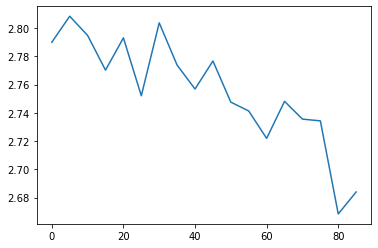

In [23]:
import matplotlib.pyplot as plt
plt.plot([i * 5 for i in range(len(all_losses))], all_losses)

In [24]:
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(line_to_tensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-2.63) Scottish
(-2.64) Czech
(-2.66) Russian

> Jackson
(-2.35) Scottish
(-2.51) Dutch
(-2.59) Irish

> Satoshi
(-2.42) Italian
(-2.67) Japanese
(-2.70) Dutch


## 代码练习

### 1. 尝试在我们的RNN模型中添加更多layers，然后观察Loss变化

In [51]:
import numpy as np
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn


def train_multi(category_tensor, line_tensor):
    hidden = rnn.initHidden()
    layer_size= 3

    rnn.zero_grad() #清空

    hidden_buffer = {}
    output_buffer={}
    for j in range(layer_size - 1):
        for i in range(line_tensor.size()[0]):
            output, hidden = rnn(line_tensor[i], hidden) #TODO:增加训练数据，要重新训练了？        
            if j > 0:
                _output = output_buffer['%s_%s'%(j-1,i)]
#                 _hidden = hidden_buffer['%s_%s'%(j-1,i)]
                output = rnn.softmax(_output) + rnn.softmax(output) # 待商榷，如何堆叠  
#                 output = rnn.softmax(_output+output)

#                 hidden = rnn.softmax(_hidden)+rnn.softmax(hidden)
#                 output = _output + output # 待商榷，如何堆叠  
#                 hidden = _hidden + hidden
                
            output_buffer['%s_%s'%(j,i)] = output
#             hidden_buffer['%s_%s'%(j,i)] = hidden
        
    loss = criterion(output, category_tensor)
    loss.backward()


    # Add parameters' gradients to their values, multiplied by learning rate

    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

In [52]:
import time
import math

n_iters = 3000 # 这个数字你可以调大一些
print_every = 100
plot_every = 100


# Keep track of losses for plotting
current_loss1 = 0
all_losses1 = []

def time_since(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = sample_trainning()
    output, loss = train_multi(category_tensor, line_tensor)

    current_loss1 += loss
#     print('output',output.topk(1))

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = category_from_output(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, time_since(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses1.append(current_loss1 / plot_every)
        current_loss1 = 0

100 3% (0m 0s) 5.5531 Maly / Irish ✗ (Polish)
200 6% (0m 0s) 1.1823 Cardona / Italian ✗ (Spanish)
300 10% (0m 1s) 3.4654 Santillian / Irish ✗ (Spanish)
400 13% (0m 1s) 2.1151 Zuniga / Japanese ✗ (Spanish)
500 16% (0m 2s) 1.4161 Kosmas / Portuguese ✗ (Greek)
600 20% (0m 2s) 0.8540 Kalb / Arabic ✓
700 23% (0m 3s) 3.6699 Hout / Vietnamese ✗ (Dutch)
800 26% (0m 3s) 0.1896 Henderson / Scottish ✓
900 30% (0m 4s) 1.3814 Franco / Italian ✗ (Portuguese)
1000 33% (0m 4s) 1.5256 Fabian / French ✓
1100 36% (0m 4s) 1.4124 Diep / Vietnamese ✓
1200 40% (0m 5s) 0.9529 Alamilla / Spanish ✓
1300 43% (0m 5s) 0.7275 Salvage / French ✓
1400 46% (0m 6s) 1.4686 Beauchene / Scottish ✗ (French)
1500 50% (0m 6s) 0.5321 Ma / Korean ✓
1600 53% (0m 7s) 0.4263 Asghar / Arabic ✓
1700 56% (0m 7s) 0.3345 Nozara / Japanese ✓
1800 60% (0m 7s) 2.4646 Martell / Irish ✗ (German)
1900 63% (0m 8s) 0.5322 Shin / Korean ✓
2000 66% (0m 8s) 0.2782 Alberici / Italian ✓
2100 70% (0m 9s) 0.9648 Williamson / Scottish ✓
2200 73% (0m 

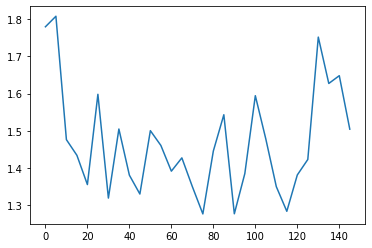

In [53]:
import matplotlib.pyplot as plt
plt.plot([i * 5 for i in range(len(all_losses1))], all_losses1)

### 2. 将原始的RNN模型改成nn.LSTM和nn.GRU， 并且改变 `n_iters = 1000 ` 这个值，观察其变化

#### LSTM

In [56]:
import torch.nn as nn
from torch.autograd import Variable

class RNN_LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size,num_layers):
        super(RNN_LSTM, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.input_size=input_size

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers)
#         self.i2h = nn.Linear(input_size + hidden_size, hidden_size) #全连接网络
        self.i2o = nn.Linear(hidden_size, output_size)
        
        self.criterion=nn.CrossEntropyLoss()
        self.softmax = nn.LogSoftmax(dim=1)
        self.tanh=nn.Tanh()
        

    def forward(self, input, hidden,cell):

        output, (hidden, cell) = self.lstm(input, (hidden, cell))
        #TODO:
        output = self.i2o(output[-1])        
        output = self.tanh(output) 
        
        return output, hidden, cell

    def initHidden(self):
            return Variable(torch.randn(self.num_layers, 1, self.hidden_size))
    def initCell(self):
            return Variable(torch.randn(self.num_layers, 1, self.hidden_size))

rnn_lstm=RNN_LSTM(n_letters,n_hidden, n_categories,1)
rnn_lstm

RNN_LSTM(
  (lstm): LSTM(57, 128)
  (i2o): Linear(in_features=128, out_features=18, bias=True)
  (criterion): CrossEntropyLoss()
  (softmax): LogSoftmax()
  (tanh): Tanh()
)

In [117]:
# lstm = nn.LSTM(30, 20, 2)
# input = Variable(torch.randn(5, 3, 30))
# h0 = Variable(torch.randn(2, 3, 20))
# c0 = Variable(torch.randn(2, 3, 20))
# output, hn = lstm(input, (h0, c0))
# # output

In [54]:
def lstm_train(category_tensor, line_tensor):
    hidden = rnn_lstm.initHidden()
    cell = rnn_lstm.initCell()

    rnn_lstm.zero_grad() #清零


    output, hidden, cell = rnn_lstm(line_tensor, hidden,cell) 

    loss = rnn_lstm.criterion(output, category_tensor)

    loss.backward()


    # Add parameters' gradients to their values, multiplied by learning rate

    for p in rnn_lstm.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()



In [63]:
import time
import math

n_iters = 10000 # 这个数字你可以调大一些
print_every = 100
plot_every = 100


# Keep track of losses for plotting
current_loss2 = 0
all_losses2 = []

def time_since(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = sample_trainning()
    output, loss = lstm_train(category_tensor, line_tensor)
    current_loss2 += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
#         print('topk',output.topk(1))
        guess, guess_i = category_from_output(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, time_since(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses2.append(current_loss2 / plot_every)
        current_loss2 = 0

100 1% (0m 0s) 2.9236 Wyrick / Italian ✗ (Polish)
200 2% (0m 0s) 2.8927 Gomulka / Italian ✗ (Polish)
300 3% (0m 1s) 2.8292 Ho / Russian ✗ (Vietnamese)
400 4% (0m 1s) 2.8815 Valentinov / Italian ✗ (Russian)
500 5% (0m 2s) 2.9161 Fung / Italian ✗ (Chinese)
600 6% (0m 2s) 2.9238 Borovski / Italian ✗ (Czech)
700 7% (0m 2s) 2.9096 Russell / Italian ✗ (English)
800 8% (0m 3s) 2.8394 Dritsas / Dutch ✗ (Greek)
900 9% (0m 3s) 2.9022 Tadhgan / Dutch ✗ (Irish)
1000 10% (0m 3s) 2.9617 Perevuznik / Italian ✗ (Czech)
1100 11% (0m 4s) 2.8682 Simon / Dutch ✗ (Irish)
1200 12% (0m 4s) 2.8760 Griggs / Italian ✗ (English)
1300 13% (0m 5s) 2.7970 Garfagnini / Dutch ✗ (Italian)
1400 14% (0m 5s) 2.9534 Olenew / Dutch ✗ (Russian)
1500 15% (0m 5s) 2.8864 Mccallum / Dutch ✗ (Scottish)
1600 16% (0m 6s) 2.9409 Yu / Italian ✗ (Korean)
1700 17% (0m 6s) 2.8853 Duncan / Dutch ✗ (Irish)
1800 18% (0m 7s) 2.9017 O'Donnell / Dutch ✗ (Irish)
1900 19% (0m 7s) 2.9088 Borovsky / Dutch ✗ (Czech)
2000 20% (0m 7s) 2.9581 Avdeef

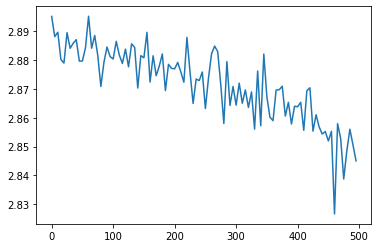

In [64]:
import matplotlib.pyplot as plt
plt.plot([i * 5 for i in range(len(all_losses2))], all_losses2)

随着训练增多，loss整体呈下降趋势

### nn.GRU

In [65]:
import torch.nn as nn
from torch.autograd import Variable

class RNN_GRU(nn.Module):
    def __init__(self, input_size, hidden_size, output_size,num_layers):
        super(RNN_GRU, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.input_size=input_size

        self.gru = nn.GRU(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers)

        self.i2o = nn.Linear(hidden_size, output_size)
        
        self.criterion=nn.CrossEntropyLoss()
        self.softmax = nn.LogSoftmax(dim=1)
        self.tanh=nn.Tanh()

    def forward(self, input, hidden):

        output, hidden = self.gru(input, hidden)
        #TODO:
        output = self.i2o(output[-1])        
        output = self.tanh(output) 
        return output, hidden

    def initHidden(self):
            return Variable(torch.zeros(self.num_layers, 1, self.hidden_size))

rnn_gru=RNN_GRU(n_letters,n_hidden, n_categories,1)
rnn_gru

RNN_GRU(
  (gru): GRU(57, 128)
  (i2o): Linear(in_features=128, out_features=18, bias=True)
  (criterion): CrossEntropyLoss()
  (softmax): LogSoftmax()
  (tanh): Tanh()
)

In [66]:
def gru_train(category_tensor, line_tensor):
    hidden = rnn_gru.initHidden()
    rnn_lstm.zero_grad() #清零

    output, hidden = rnn_gru(line_tensor, hidden) #TODO:增加训练数据，要重新训练了？
    
    loss = rnn_lstm.criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate

    for p in rnn_lstm.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()



In [73]:
import time
import math

n_iters = 20000 # 这个数字你可以调大一些
print_every = 500
plot_every = 100


# Keep track of losses for plotting
current_loss3 = 0
all_losses3 = []

def time_since(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = sample_trainning()
    output, loss = gru_train(category_tensor, line_tensor)
    current_loss3 += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = category_from_output(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, time_since(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses3.append(current_loss3 / plot_every)
        current_loss3 = 0

500 2% (0m 2s) 2.8365 Duncan / Vietnamese ✗ (Scottish)
1000 5% (0m 4s) 2.8524 Koo / Scottish ✗ (Korean)
1500 7% (0m 5s) 2.8128 Wood / Vietnamese ✗ (Scottish)
2000 10% (0m 7s) 2.9561 Parnaby / Vietnamese ✗ (English)
2500 12% (0m 9s) 2.8190 Cao / Scottish ✗ (Vietnamese)
3000 15% (0m 11s) 2.9190 Onegin / Vietnamese ✗ (Russian)
3500 17% (0m 14s) 2.8158 Dao / Vietnamese ✓
4000 20% (0m 15s) 2.8894 Conall / Scottish ✗ (Irish)
4500 22% (0m 18s) 2.8726 William / Vietnamese ✗ (Irish)
5000 25% (0m 19s) 2.9244 Akera / Vietnamese ✗ (Japanese)
5500 27% (0m 21s) 2.9062 Vyazalov / Vietnamese ✗ (Russian)
6000 30% (0m 23s) 2.9565 Said / Vietnamese ✗ (Arabic)
6500 32% (0m 25s) 2.9506 Ieyasu / Scottish ✗ (Japanese)
7000 35% (0m 27s) 2.9838 Soriano / Scottish ✗ (Italian)
7500 37% (0m 29s) 2.9228 Simon / Vietnamese ✗ (French)
8000 40% (0m 31s) 2.8846 Nunes / Vietnamese ✗ (Portuguese)
8500 42% (0m 33s) 2.9301 Murata / Czech ✗ (Japanese)
9000 45% (0m 35s) 2.8308 Bang / Vietnamese ✗ (Korean)
9500 47% (0m 37s) 

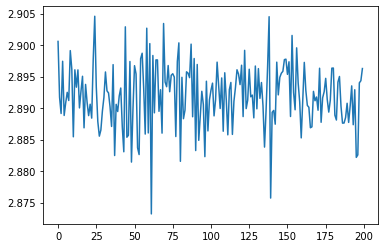

In [74]:
plt.plot(all_losses3)

训练增加，但loss整体没有下降，准确率也很低，可能是模型哪里有问题

### 3. 把该RNN模型变成多层RNN模型，观察Loss的变化

In [99]:
import torch.nn as nn
from torch.autograd import Variable

class RNN_GRU_MULTI(nn.Module):
    def __init__(self, input_size, hidden_size, output_size,num_layers):
        super(RNN_GRU_MULTI, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.input_size=input_size

        self.gru = nn.GRU(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers)

        self.i2o = nn.Linear(hidden_size, output_size)
        
        self.criterion=nn.CrossEntropyLoss()
        self.softmax = nn.LogSoftmax(dim=1)
        self.tanh=nn.Tanh()

    def forward(self, input, hidden,num_layers):
        for i in range(num_layers):
            output, hidden = self.gru(input, hidden)
            output = self.i2o(output[-1])        
            output = self.tanh(output) 

        
        return output, hidden,num_layers

    def initHidden(self):
            return Variable(torch.zeros(self.num_layers, 1, self.hidden_size))

rnn_gru_multi=RNN_GRU_MULTI(n_letters,n_hidden, n_categories,3)
rnn_gru_multi

RNN_GRU_MULTI(
  (gru): GRU(57, 128, num_layers=3)
  (i2o): Linear(in_features=128, out_features=18, bias=True)
  (criterion): CrossEntropyLoss()
  (softmax): LogSoftmax()
  (tanh): Tanh()
)

In [100]:
def gru_train_multi(category_tensor, line_tensor,num_layer):
    hidden = rnn_gru_multi.initHidden()
#     print('hidden',hidden.shape)
    rnn_lstm.zero_grad() #清零
    
#     for i in range(num_layer):
    output, hidden,num_layer = rnn_gru_multi(line_tensor, hidden,num_layer) #TODO:增加训练数据，要重新训练了？

    loss = rnn_gru_multi.criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate

    for p in rnn_gru_multi.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()



In [101]:
import time
import math

n_iters = 12000 # 这个数字你可以调大一些
print_every = 500
plot_every = 100
num_layer=3

# Keep track of losses for plotting
current_loss4 = 0
all_losses4 = []

def time_since(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = sample_trainning()
    output, loss = gru_train_multi(category_tensor, line_tensor,num_layer)
    current_loss4 += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = category_from_output(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, time_since(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses4.append(current_loss4 / plot_every)
        current_loss4 = 0

500 4% (0m 14s) 2.3242 Park  / Czech ✗ (Korean)
1000 8% (0m 28s) 4.3242 Grec / Czech ✗ (Spanish)
1500 12% (0m 43s) 2.3242 Koziol / Czech ✗ (Polish)
2000 16% (0m 57s) 2.3242 Fearon / Czech ✗ (English)
2500 20% (1m 12s) 2.3242 Dou / Czech ✗ (Chinese)
3000 25% (1m 27s) 4.3242 Trang / Czech ✗ (Vietnamese)
3500 29% (1m 40s) 2.3242 Garcia / Czech ✗ (Portuguese)
4000 33% (1m 54s) 4.3242 Moraitopoulos / Czech ✗ (Greek)
4500 37% (2m 7s) 4.3242 Villeneuve / Czech ✗ (French)
5000 41% (2m 21s) 2.3242 Abbott / Czech ✗ (English)
5500 45% (2m 35s) 2.3242 Hawley / Czech ✗ (English)
6000 50% (2m 48s) 4.3242 Montero / Czech ✗ (Spanish)
6500 54% (3m 2s) 4.3242 Seighin / Czech ✗ (Irish)
7000 58% (3m 15s) 2.3242 Kemp / Czech ✗ (English)
7500 62% (3m 29s) 4.3242 Takabe / Czech ✗ (Japanese)
8000 66% (3m 42s) 2.3242 Whyte / Czech ✗ (Scottish)
8500 70% (3m 56s) 4.3242 Siegel / Czech ✗ (German)
9000 75% (4m 9s) 2.3242 Greenaway / Czech ✗ (English)
9500 79% (4m 23s) 4.3242 Said / Czech ✗ (Arabic)
10000 83% (4m 3

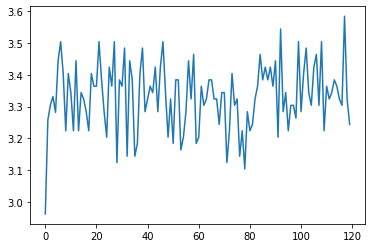

In [102]:
plt.plot(all_losses4)

### 4. Pytorch里边常用nn.NLLoss来代替crossentropy，将criterion改为nn.NLLoss，观察变化

In [104]:
import torch.nn as nn
from torch.autograd import Variable

class RNN_GRU_MULTI2(nn.Module):
    def __init__(self, input_size, hidden_size, output_size,num_layers):
        super(RNN_GRU_MULTI2, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.input_size=input_size

        self.gru = nn.GRU(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers)

        self.i2o = nn.Linear(hidden_size, output_size)
        
        self.criterion=nn.NLLLoss()
        self.softmax = nn.LogSoftmax(dim=1)
        self.tanh=nn.Tanh()

    def forward(self, input, hidden, num_layers):
        for i in range(num_layers):
            output, hidden = self.gru(input, hidden)
            output = self.i2o(output[-1])        
            output = self.tanh(output) 

        
        return output, hidden, num_layers

    def initHidden(self):
#             return [torch.zeros(1, self.hidden_size) for i in self.num_layers]
            return Variable(torch.zeros(self.num_layers, 1, self.hidden_size))

rnn_gru_multi2=RNN_GRU_MULTI2(n_letters,n_hidden, n_categories,3)
rnn_gru_multi2

RNN_GRU_MULTI2(
  (gru): GRU(57, 128, num_layers=3)
  (i2o): Linear(in_features=128, out_features=18, bias=True)
  (criterion): NLLLoss()
  (softmax): LogSoftmax()
  (tanh): Tanh()
)

In [105]:
def gru_train_multi2(category_tensor, line_tensor,num_layer):
    hidden = rnn_gru_multi.initHidden()
#     print('hidden',hidden.shape)
    rnn_lstm.zero_grad() #清零
    
#     for i in range(num_layer):
    output, hidden,num_layer = rnn_gru_multi2(line_tensor, hidden,num_layer) #TODO:增加训练数据，要重新训练了？

    loss = rnn_gru_multi.criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate

    for p in rnn_gru_multi.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()



In [111]:
import time
import math

n_iters = 2000 # 这个数字你可以调大一些
print_every = 200
plot_every = 100
num_layer=3

# Keep track of losses for plotting
current_loss5 = 0
all_losses5 = []

def time_since(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = sample_trainning()
    output, loss = gru_train_multi2(category_tensor, line_tensor,num_layer)
    current_loss5 += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = category_from_output(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, time_since(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses5.append(current_loss5 / plot_every)
        current_loss5 = 0

200 10% (0m 5s) 3.0196 Karkampasis / Polish ✗ (Greek)
400 20% (0m 11s) 2.8592 Shriver / Polish ✗ (German)
600 30% (0m 17s) 2.8406 Fakhoury / Polish ✗ (Arabic)
800 40% (0m 23s) 2.8892 Miller / Polish ✗ (Scottish)
1000 50% (0m 29s) 3.0114 Totolos / Polish ✗ (Greek)
1200 60% (0m 36s) 2.9711 Paulis / Polish ✗ (Dutch)
1400 70% (0m 42s) 2.8395 Naifeh / Polish ✗ (Arabic)
1600 80% (0m 48s) 2.7898 Kell / Polish ✗ (English)
1800 90% (0m 54s) 2.8459 Kim / Polish ✗ (Korean)
2000 100% (1m 0s) 2.9877 Awdiewsky / Polish ✗ (Russian)


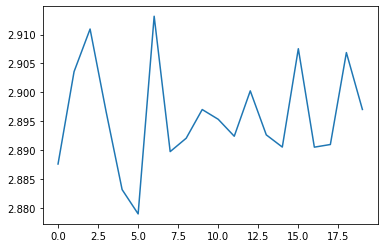

In [112]:
plt.plot(all_losses5)